In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,8)

In [4]:
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
region = 'prd'
sample_region = 'PRD'
# region = 'tibet'
# sample_region = 'TIBET'

In [5]:
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2020-01-01', '2020-12-31')
image = l8.map(maskSR).median().clip(roi)
ref_img = image.visualize(**{'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4})
Map.addLayer(image, visParams,'image median')

In [6]:
year = 2019
JRC_id = 'JRC/GSW1_3/YearlyHistory/' + str(year)
Maryland_id = 'users/311605001111/Maryland/Maryland_nationwide_' + str(year)
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
JRC = ee.Image(JRC_id).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC,basemap]).sum()
Maryland = ee.Image(Maryland_id).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
permanentWaterExtent = ee.ImageCollection([JRC_waterclass.eq(2),Maryland_waterclass.eq(2)]).sum().eq(2)
landExtent = ee.ImageCollection([JRC_waterclass.eq(0),Maryland_waterclass.eq(0)]).sum().eq(2)
seasonWaterExtent_min = ee.ImageCollection([JRC_waterclass.eq(1),Maryland_waterclass.eq(1)]).sum().eq(2)
seasonWaterExtent_max = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')

In [7]:
pw = permanentWaterExtent.remap([0,1],[0,3]).rename('waterclass')
ld = landExtent.rename('waterclass')
sw = seasonWaterExtent_min.remap([0,1],[0,2]).rename('waterclass')
total = ee.ImageCollection([pw,sw,ld]).sum()
# Map.addLayer(total, {'palette':['white','#F7FCF0','#87CEFA','blue'],'min':0,'max':3},'total')
Map.addLayer(total.selfMask(), {'palette':['#F7FCF0','#87CEFA','blue'],'min':1,'max':3},'total')

In [8]:
name = 'Region D'
year = 2019

pw_nw_n = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_noseason' + str(year))
pw_nw = pw_nw_n.map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)}))
permanent_water = pw_nw.filter(ee.Filter.eq('waterclass',1)).randomColumn('random',1,'uniform').sort('random').limit(500)
no_water = pw_nw.filter(ee.Filter.eq('waterclass',0)).randomColumn('random',1,'uniform').sort('random').limit(3000)
print('抽样的永久性水体： ',permanent_water.size().getInfo())
print('抽样的非水体： ',no_water.size().getInfo())
## 季节性样本，抽样
# sww = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year)+'_v2')
sww = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_season' + str(year))
sw = sww.map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)})).randomColumn('random',1,'uniform').sort('random').limit(500)
print('抽样的季节性水体： ',sw.size().getInfo())
## 季节性样本，分类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
cluster_samples = ee.FeatureCollection([permanent_water,no_water]).flatten()
clusterer = ee.Clusterer.wekaKMeans(2).train(cluster_samples,bands)
q = ee.FeatureCollection(sw.cluster(clusterer))
q1 = q.filter(ee.Filter.eq('cluster',1))
q0 = q.filter(ee.Filter.eq('cluster',0))
b1 = ee.FeatureCollection(q1).filter(ee.Filter.lt('AWEI',0)).size()
b2 = ee.FeatureCollection(q1).filter(ee.Filter.gt('AWEI',0)).size()
c1 = ee.FeatureCollection(q0).filter(ee.Filter.lt('AWEI',0)).size()
c2 = ee.FeatureCollection(q0).filter(ee.Filter.gt('AWEI',0)).size()
qq1 = ee.Algorithms.If(ee.Number(b1).lt(ee.Number(b2)),q1.map(lambda i:i.set({'waterclass':1})),q1.map(lambda i:i.set({'waterclass':0})))
qq0 = ee.Algorithms.If(ee.Number(c1).lt(ee.Number(c2)),q0.map(lambda i:i.set({'waterclass':1})),q0.map(lambda i:i.set({'waterclass':0})))
seasonWater = ee.FeatureCollection([qq1,qq0]).flatten()
## 合并
total_Samples = ee.FeatureCollection([permanent_water,no_water,seasonWater]).flatten()
print("筛选前，剩余的样本数： ",total_Samples.size().getInfo())


抽样的永久性水体：  500
抽样的非水体：  3000
抽样的季节性水体：  468
筛选前，剩余的样本数：  3968


In [9]:
nowater = total_Samples.filter(ee.Filter.eq('waterclass',0))
print(nowater.size().getInfo())
water = total_Samples.filter(ee.Filter.eq('waterclass',1))
print(water.size().getInfo())

3395
573


Text(0.5, 1.0, 'Range distribution of various waterbodies')

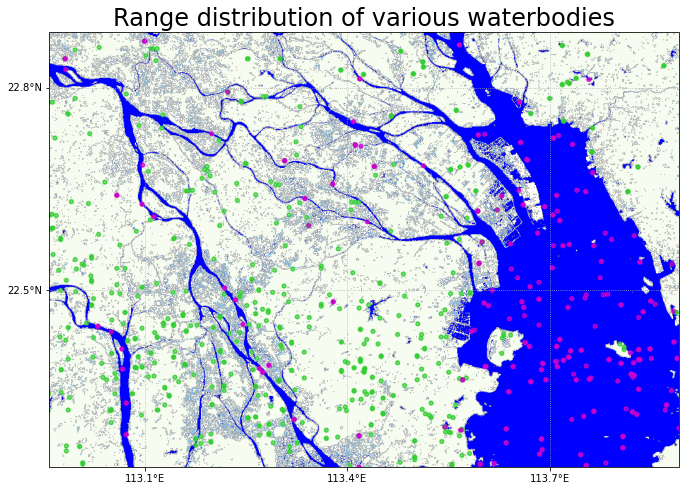

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# re = [114.0514, 22.2347, 112.7614, 23.2547]
re = [113.8923, 22.2386, 112.9587, 22.8829]

# re = [115.0993, 29.8642, 113.7393, 30.9242]
# re = [115.9244, 38.6272,117.4944,39.6372]
visParams = {'palette':['#F7FCF0','#87CEFA','blue'],'min':1,'max':3}
fig = plt.figure(figsize=(12, 8))

refer_img = total.selfMask().visualize(**visParams)
nowater = total_Samples.filter(ee.Filter.eq('waterclass',0)).draw('#33cc33')
water = total_Samples.filter(ee.Filter.eq('waterclass',1)).draw('#CC00CC')
blend = refer_img.blend(nowater).blend(water)

ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = 'Range distribution of various waterbodies', fontsize=24)

Text(0.5, 1.0, 'Standard false-colour images')

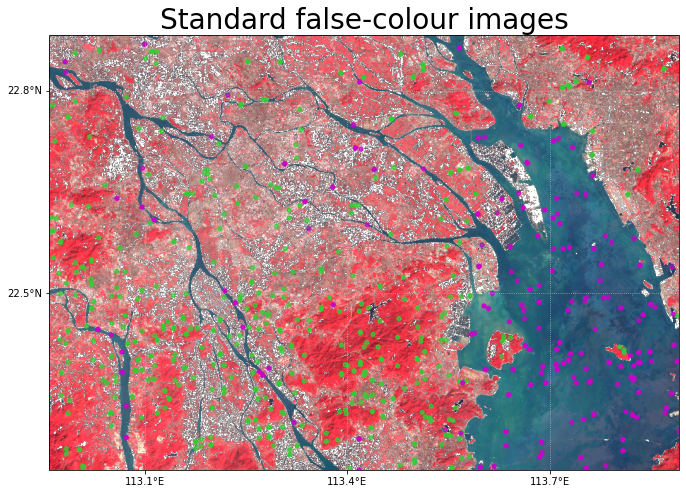

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [113.8923, 22.2386, 112.9587, 22.8829]
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
fig = plt.figure(figsize=(12, 8))

ref_img = ee.Image("users/311605001111/basemap_image/prd_allband").visualize(**visParams)
img = ref_img.updateMask(total.selfMask())
nowater = total_Samples.filter(ee.Filter.eq('waterclass',0)).draw('#33cc33')
water = total_Samples.filter(ee.Filter.eq('waterclass',1)).draw('#CC00CC')
blend = img.blend(nowater).blend(water)

ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = 'Standard false-colour images', fontsize=28)